# Machine Learning Models 
# Project 3 
## Youtube Trending Videos Analysis and Prediction
### José Alejandro Guzmán Zamora 

In [1]:
"""
Librerías a utilizar a lo largo del proyecto. Cada una tiene un 
propósito específico que se puede verificar en los comentarios 
siguientes si se desea. 
"""

# Librerías de manejo de dataset y demás estructuras de datos
import pandas as pd 
import numpy as np 

# Librerías de visualizaciones, seaborn trabaja sobre matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# Librerías para realizar cross validation sobre los modelos generados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Evaluación de cross validation va a depender de ciertas métricas 
from sklearn import metrics 

# Modelos a utilizar 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Herramientas especiales para visualizar decision trees
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus

%matplotlib inline

d:\cs7\machine learning models\mlenv\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Exploración y Transformación de Datos

In [2]:
"""
El dataset incluye información de videos que aparecieron en la pestaña
de trending de Youtube por ciertos países. El objetivo del proyecto 
es poder determinar si un video va a poder ser trending a nivel internacional,
tomando como base los videos que aparecen por primera vez en Estados Unidos. 

A continuación se hace la lectura de todos los datasets, importante notar que 
a causa del lenguaje se tuvo que utilizar encoding distinto para ciertos países
con caracteres especiales. 
"""


total = []
total.append(pd.read_csv('./CAvideos.csv'))
total.append(pd.read_csv('./DEvideos.csv'))
total.append(pd.read_csv('./FRvideos.csv'))
total.append(pd.read_csv('./GBvideos.csv'))
total.append(pd.read_csv('./INvideos.csv'))
total.append(pd.read_csv('./JPvideos.csv',encoding='latin1'))
total.append(pd.read_csv('./KRvideos.csv',encoding='latin1'))
total.append(pd.read_csv('./MXvideos.csv',encoding='latin1'))
total.append(pd.read_csv('./RUvideos.csv',encoding='latin1'))
us = pd.read_csv('./USvideos.csv')

In [3]:
"""
Cada uno de los datasets no incluye el valor de target que se quiere determinar, 
por lo tanto, es necesario realizar algunas transformaciones. Como primer punto 
se eliminan los registros repetidos. 

Posteriormente se crea una columna auxiliar que va a calcular la cantidad de países
en los que cada video estuvo en trending. Por supuesto todos comienzan en 1 pues ya
son parte del dataset base, el de Estados Unidos. 
"""

base_data = us.copy()
base_continuar = base_data.drop_duplicates(subset=[base_data.columns[0]],keep='first')
base_continuar['international'] = 1

d:\cs7\machine learning models\mlenv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [4]:
"""
La siguiente función hace la revisión de la cantidad de países en los que apareció 
cada video. Para no hacer el recorrido completo del dataframe por cada país, lo que se
hizo fue una lista de identificadores por país y se verificó si cada video estaba dentro 
del mismo. Si bien es cierto el costo sigue siendo de O(n)*m en donde n es la cantidad de 
observaciones de US y m es la cantidad de países adicionales; hacer la búsqueda solo por medio
de comparaciones de identificadores es una manera más eficiente en cuanto a memoria. 
"""
def verificacion_us(datas):
    for i in datas:
        temporal = i.copy()
        temporal_continuar = temporal.drop_duplicates(subset=[temporal.columns[0]],keep='first')
        for i in range(base_continuar.shape[0]):
            if base_continuar.iloc[i,:]['video_id'] in temporal_continuar['video_id'].values:
                base_continuar.iloc[i,-1] += 1
verificacion_us(total)

d:\cs7\machine learning models\mlenv\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
"""
Verificación rápida de cómo resultó la distribución, debido al propósito del 
proyecto, se hará un conjunto de los que estuvieron en 2 o más países para los
internacionales.
"""

base_continuar['international'].value_counts()

1     3461
2     1493
3      589
4      273
5      192
6      141
7      101
8       55
9       37
10       9
Name: international, dtype: int64

In [6]:
"""
Crear la columna target que será nuestra response variable y hacer la
operación de comparación respectiva para determinar si cada uno de los 
videos es internacional (1) o no (0).
"""

base_continuar['target'] = 0
base_continuar.loc[base_continuar['international'] > 1, 'target'] = 1
data = base_continuar.drop(['international'],1)
data.head()

d:\cs7\machine learning models\mlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,target
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,1
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",1
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,1
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,1
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,1


In [7]:
data.tail()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,target
40760,dS5Thrl-4Kc,18.14.06,CRAYOLA MAKEUP | HIT OR MISS?,Laura Lee,26,2018-06-12T18:55:26.000Z,"Laura88Lee|""crayola""|""crayon makeup""|""crayola ...",607422,26166,895,3517,https://i.ytimg.com/vi/dS5Thrl-4Kc/default.jpg,False,False,False,"Hey Larlees, todays video is me testing Crayol...",0
40761,JGm9Y_hFqNk,18.14.06,First Take reacts: Kyrie Irving says contract ...,ESPN,17,2018-06-13T15:06:08.000Z,"espn|""espn live""|""boston celtics""|""kyrie irvin...",812832,7701,320,2505,https://i.ytimg.com/vi/JGm9Y_hFqNk/default.jpg,False,False,False,First Take's Stephen A. Smith and Max Kellerma...,1
40762,6h8QgZF5Qu4,18.14.06,Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs,The Late Late Show with James Corden,24,2018-06-13T05:27:27.000Z,"The Late Late Show|""Late Late Show""|""James Cor...",864189,18811,399,1074,https://i.ytimg.com/vi/6h8QgZF5Qu4/default.jpg,False,False,False,James Corden and Ashton Kutcher square off in ...,1
40764,mpnshdmtE2Y,18.14.06,Carla Makes BA Smashburgers | From the Test Ki...,Bon Appétit,26,2018-06-12T16:03:58.000Z,"bon appetit|""burgers""|""cheeseburgers""|""how to ...",540149,14206,693,1211,https://i.ytimg.com/vi/mpnshdmtE2Y/default.jpg,False,False,False,"Ground chuck is a great all-purpose, buy-it-an...",1
40766,yz7Xq3T0YPs,18.14.06,"Katherine Langford on 13 Reasons Why, Australi...",Jimmy Kimmel Live,24,2018-06-13T09:00:06.000Z,"jimmy|""kimmel""|""live""|""late""|""night""|""talk""|""s...",296295,8157,294,764,https://i.ytimg.com/vi/yz7Xq3T0YPs/default.jpg,False,False,False,"Katherine talks about learning accents, growin...",0


In [8]:
"""
Overview del dataframe, podemos verificar que hay 3 de tipo boolean 
(posteriormente se transformarán), hay 6 de enteros y hay 8 columnas
de tipo objeto. Esa información es útil para determinar las features 
que de cajón no nos van a ser útiles, así como lo va a ser un identificador
de video. 
"""

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 0 to 40766
Data columns (total 17 columns):
video_id                  6351 non-null object
trending_date             6351 non-null object
title                     6351 non-null object
channel_title             6351 non-null object
category_id               6351 non-null int64
publish_time              6351 non-null object
tags                      6351 non-null object
views                     6351 non-null int64
likes                     6351 non-null int64
dislikes                  6351 non-null int64
comment_count             6351 non-null int64
thumbnail_link            6351 non-null object
comments_disabled         6351 non-null bool
ratings_disabled          6351 non-null bool
video_error_or_removed    6351 non-null bool
description               6249 non-null object
target                    6351 non-null int64
dtypes: bool(3), int64(6), object(8)
memory usage: 1.1+ MB


In [9]:
"""
En el siguiente arreglo se colocarón las variables que nos resultarán
inútiles. Además para aprovechar la data de los tags utilizados, 
se realizó un split para obtener información de la cantidad de tags
que se utilizan en cada video. Posteriormente se comprobará si esta columna
va a ser de ayuda para la predicción. 
"""

unusable_variables = ['trending_date','publish_time','video_id', 
                      'title', 'thumbnail_link','description', 'channel_title']
data_usar = data.drop(unusable_variables,1)

auxiliar = [len(data_usar.iloc[i,1].split('|')) for i in range(len(data_usar))]
data_usar.drop(['tags'],1,inplace=True)
data_usar['ntags'] = auxiliar

In [11]:
"""
Tal como se mencionó, se colocó cada columna boolean como una binaria.
En el nuevo info se puede ver que nuestros valores ya son todos numéricos,
sin embargo, todavía hace falta un poco de investigación en cuanto a la 
columna de category_id. 
"""

data_usar['comments_disabled'] = data_usar['comments_disabled'].astype(int)
data_usar['ratings_disabled'] = data_usar['ratings_disabled'].astype(int)
data_usar['video_error_or_removed'] = data_usar['video_error_or_removed'].astype(int)

data_usar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 0 to 40766
Data columns (total 10 columns):
category_id               6351 non-null int64
views                     6351 non-null int64
likes                     6351 non-null int64
dislikes                  6351 non-null int64
comment_count             6351 non-null int64
comments_disabled         6351 non-null int32
ratings_disabled          6351 non-null int32
video_error_or_removed    6351 non-null int32
target                    6351 non-null int64
ntags                     6351 non-null int64
dtypes: int32(3), int64(7)
memory usage: 791.4 KB


In [12]:
"""
Datos estadísticos básicos para entender un poco más el dataset.
"""

data_usar.describe()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,target,ntags
count,6351.000000,6.351000e+03,6.351000e+03,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000
mean,20.444182,7.582096e+05,3.449357e+04,1427.222012,4501.707290,0.015903,0.004094,0.000472,0.455046,19.852937
std,7.213046,1.928993e+06,1.162439e+05,12078.814524,21460.223331,0.125110,0.063857,0.021731,0.498014,12.174717
min,1.000000,5.490000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,8.351100e+04,1.908000e+03,72.000000,261.000000,0.000000,0.000000,0.000000,0.000000,10.000000
50%,24.000000,2.709020e+05,7.987000e+03,242.000000,921.000000,0.000000,0.000000,0.000000,0.000000,19.000000
75%,25.000000,7.512665e+05,2.516300e+04,763.000000,2845.000000,0.000000,0.000000,0.000000,1.000000,29.000000
max,43.000000,4.843165e+07,3.880071e+06,629120.000000,733373.000000,1.000000,1.000000,1.000000,1.000000,69.000000


In [13]:
"""
Antes de continuar con la exploración, hay que ver si hay 
presencia de datos nulos. Afortunadamente no hay que hacer 
imputación ni eliminación. 
"""
data_usar.isna().sum()

category_id               0
views                     0
likes                     0
dislikes                  0
comment_count             0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
target                    0
ntags                     0
dtype: int64

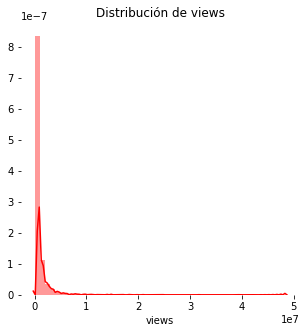

In [31]:
"""
Distribución de las vistas. Se puede ver claramente que 
hay una distribución logarítmica.
"""

def plot_dist(value,log):
    fig = plt.figure(figsize=(5,5))
    axtemp = fig.add_subplot(111)
    axtemp.spines['top'].set_visible(False)
    axtemp.spines['right'].set_visible(False)
    axtemp.spines['bottom'].set_visible(False)
    axtemp.spines['left'].set_visible(False)
    if log:
        sns.distplot(np.log(data_usar[value] + 1),color="red")
    else:
        sns.distplot(data_usar[value],color="red")
    plt.title("Distribución de " + value)
    plt.show()

plot_dist('views',False)

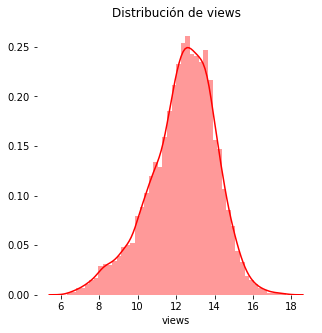

In [32]:
"""
Al aplicar un logaritmo a la distribución original, se 
obtiene una distribución más normal con un leve sesgo 
a la izquierda. Sin embargo, muchos de los algoritmos 
que se utilizarán no hacen ninguna suposición de la 
distribución de los datos. 
"""

plot_dist('views',True)

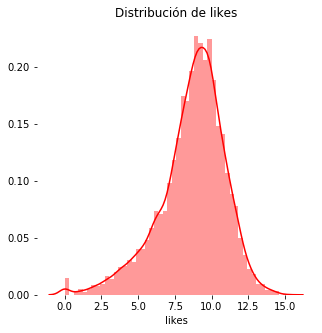

In [33]:
plot_dist('likes',True)

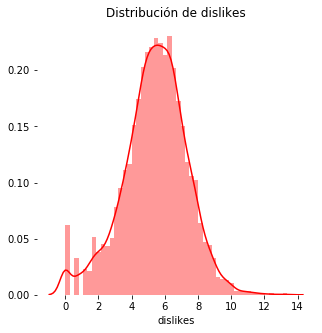

In [34]:
plot_dist('dislikes',True)

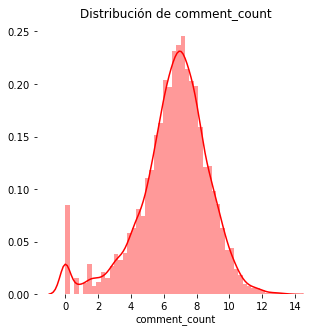

In [35]:
plot_dist('comment_count',True)

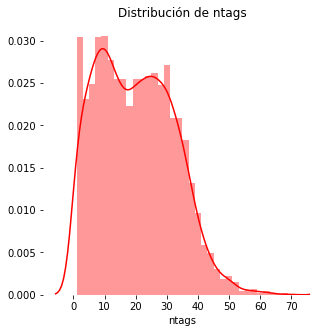

In [36]:
plot_dist('ntags',False)

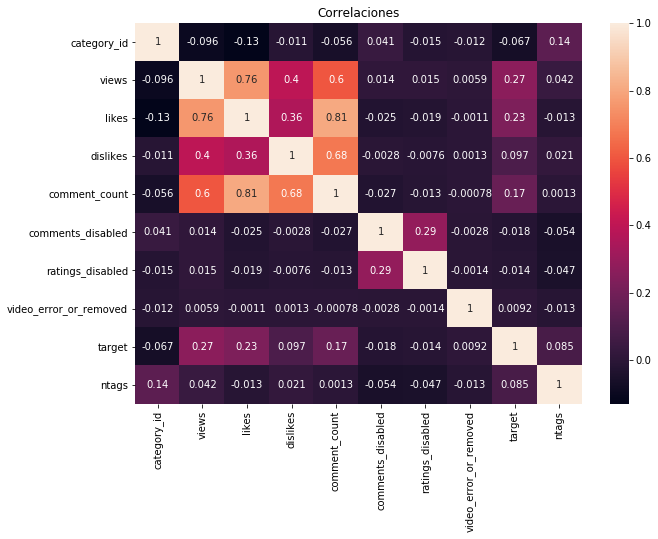

In [44]:
"""
Al momento ya se tiene un entendimiento mayor de la información. 
Ahora vamos a aprovechar la herramienta del heatmap para verificar
qué posibles correlaciones hay entre las variables y comenzar con
la selección de las mismas. Desafortunadamente al comparar el target 
con las variables no hay correlación notable. Lo que se puede ver es 
una ligera correlación con los features de views, likes, dislikes y 
comments count. 
"""

fig = plt.figure(figsize=(10,7))
correlation = data_usar.corr()
sns.heatmap(correlation,annot=True)
plt.title("Correlaciones")
plt.show()

In [46]:
"""
Las correlaciones revelaron que la categoría en realidad no es de mucha 
ayuda en cuanto a relación con el target. Sin embargo, para no dejar de 
explorarla se realiza el siguiente cambio con un propósito ilustrativo
y de visualización. 
"""

ayuda = ["Film & Animation","Autos & Vehicles","Music","Pets & Animals",
        "Sports","Travel & Events","Gaming","People & Blogs","Comedy",
        "Entertainment","News & Politics","Howto & Style","Education",
        "Science & Technology","Nonprofits & Activism","Shows"]
auxiliar_ayuda = [1,2,10,15,17,19,20,22,23,24,25,26,27,28,29,43]
for i in range(len(ayuda)):
    data_usar.loc[data_usar['category_id'] == auxiliar_ayuda[i], 'category_id'] = ayuda[i]

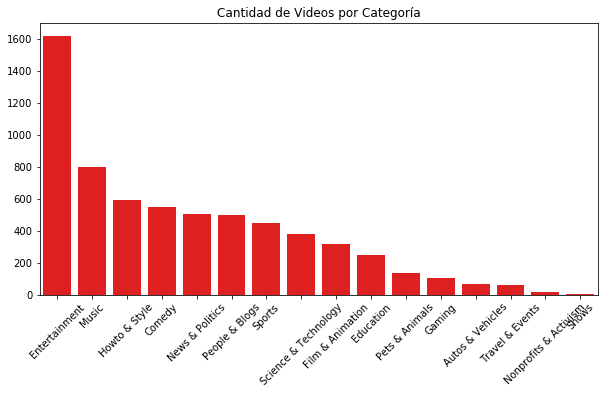

In [50]:
"""
Visualización de videos por categoría. 
"""

counts = data_usar['category_id'].value_counts()
indices = counts.index.to_numpy()
valores = counts.to_numpy()
plt.figure(figsize=(10,5))
barra_categoria = sns.barplot(x=indices, y=valores,color='red')
barra_categoria.set_xticklabels(barra_categoria.get_xticklabels(), rotation=45)
plt.title("Cantidad de Videos por Categoría")
plt.show()

In [51]:
"""
Es importante aclarar que los siguientes 3 features están tremendamente
desbalanceados. No es recomendable hacer transformaciones de under u
oversampling para este caso. Además quedan descartadas como columnas 
útiles. 
"""

print(data_usar['comments_disabled'].value_counts())
print(data_usar['ratings_disabled'].value_counts())
print(data_usar['video_error_or_removed'].value_counts())

0    6250
1     101
Name: comments_disabled, dtype: int64
0    6325
1      26
Name: ratings_disabled, dtype: int64
0    6348
1       3
Name: video_error_or_removed, dtype: int64


In [58]:
"""
Finalmente hay que regresar la variable category a un estado 
numérico, esto se hace por medio de one hot encoding. 
"""

test = pd.get_dummies(data_usar['category_id'])
temporal = data_usar.drop(['category_id'],1)
verificar_porfa = pd.concat([test,temporal], axis=1, sort=False)
data = verificar_porfa.copy()

## Entrenamiento, Predicciones y Evaluación

In [69]:
"""
Preparar la separación del dataset para el cross validation. En 
este caso se utilizará KFold CV para tener un resultado más 
consistente con la totalidad de datos disponibles. 
"""

Y = data['target'].to_numpy().ravel()
X = data.drop(['target'],1).to_numpy()

In [78]:
"""
Función para poder utilizar cross validation de manera automática. 
"""

def cross_validation(model,x,y,splits):
    resultados = []
    cv = KFold(n_splits=10, shuffle=True)
    contador = 0
    for traini, testi in cv.split(x):
        contador += 1

        x_train, x_test, y_train, y_test = x[traini],x[testi],y[traini],y[testi]
        modelin = model.fit(x_train, y_train)
        prediccion = modelin.predict(x_test)
        resultados.append(metrics.accuracy_score(y_test,prediccion))
    return (resultados,np.mean(resultados))

In [81]:
primer_decision_tree = cross_validation(DecisionTreeClassifier(max_depth=5),X,Y,10)
print("Resultados generales: \n",primer_decision_tree[0])
print("\nMean Test Score: ",primer_decision_tree[1])

Resultados generales: 
 [0.7657232704402516, 0.7779527559055118, 0.7385826771653543, 0.7622047244094489, 0.7244094488188977, 0.7543307086614173, 0.7496062992125985, 0.7937007874015748, 0.7716535433070866, 0.7496062992125985]

Mean Test Score:  0.758777051453474


In [85]:
"""
Anteriormente verificamos que las siguientes variables son las que mayor
correlación tienen con el target, por lo tanto se evaluará el desempeño
sin otras variables que podrían estar afectando al modelo. Hay algo muy 
importante que debemos notar, con notablemente menos features se obtuvo 
un desempeño prácticamente igual. Esto nos indica que las variables 
seleccionadas verdaderamente son útiles. 
"""
better = ['views','likes','dislikes','comment_count','ntags']
X2 = data.drop(['target'],1)[better].to_numpy()

segundo_decision_tree = cross_validation(DecisionTreeClassifier(max_depth=5),X2,Y,10)
print("Resultados generales: \n",segundo_decision_tree[0])
print("\nMean Test Score: ",segundo_decision_tree[1])

Resultados generales: 
 [0.7594339622641509, 0.7039370078740157, 0.75748031496063, 0.7433070866141732, 0.7622047244094489, 0.7748031496062993, 0.7496062992125985, 0.75748031496063, 0.7637795275590551, 0.7433070866141732]

Mean Test Score:  0.7515339474075174


In [111]:
dot_data = StringIO()
export_graphviz(arbolin2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = better,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
img = Image(graph.create_png())

In [114]:
with open("first.png", "wb") as png:
    png.write(graph.create_png())

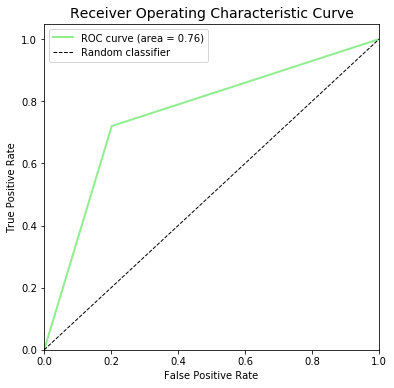

In [116]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = metrics.roc_curve(y_test, prediccion2)
roc_auc = metrics.auc(fpr, tpr)
f,ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, color='lightgreen',lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve',fontsize=14)
ax.legend()
plt.show()

In [139]:
bagging = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=200,
                            bootstrap=True, 
                            max_samples=5,
                            oob_score = False,
                            n_jobs=-1)
bagging.fit(x_train[better],y_train)
y_pred_bagging = bagging.predict(x_test[better])
res = metrics.accuracy_score(y_test,y_pred_bagging)
res

0.7631785995279308

In [142]:
rand_forest = RandomForestClassifier(max_leaf_nodes=10,
                                     bootstrap=True,
                                     max_samples=5,
                                     random_state=42,
                                     n_estimators=500,
                                     n_jobs=-1)
# train the classifier
rand_forest.fit(x_train, y_train)
# predict
y_pred = rand_forest.predict(x_test)
# plot ROC
res = metrics.accuracy_score(y_test,y_pred)
res

0.7663257277734068

In [143]:
feature_imp = pd.Series(rand_forest.feature_importances_,index=list(x_train.columns.values)).sort_values(ascending=False)
feature_imp

views                     0.197290
comment_count             0.167197
likes                     0.164544
dislikes                  0.161329
ntags                     0.122066
Entertainment             0.043510
People & Blogs            0.024092
Music                     0.019285
Howto & Style             0.016263
Science & Technology      0.015275
Comedy                    0.014759
News & Politics           0.013299
Sports                    0.011663
Education                 0.006885
Film & Animation          0.005927
Pets & Animals            0.005426
Gaming                    0.005323
comments_disabled         0.003642
Travel & Events           0.001224
Autos & Vehicles          0.000649
ratings_disabled          0.000354
Nonprofits & Activism     0.000000
video_error_or_removed    0.000000
Shows                     0.000000
dtype: float64

In [171]:


AdaBoost = AdaBoostClassifier(n_estimators=100, learning_rate=1.9).fit(x_train[better],y_train)
c_pred_train = AdaBoost.score(x_train[better],y_train)
c_pred_test = AdaBoost.score(x_test[better],y_test)
print(c_pred_train)
print(c_pred_test)

0.7696850393700787
0.7584579071597167


In [181]:
train_matrix = xgb.DMatrix(x_train[better], label=y_train)
test_matrix = xgb.DMatrix(x_test[better], label=y_test)

parameters = {'booster': 'gbtree',
              'max_depth': 5, 
              'eta': 0.8, 
              'gamma': .01}

boost_rounds = 30
bst = xgb.train(parameters, train_matrix, boost_rounds)

y_train_pred = bst.predict(train_matrix)
y_test_pred = bst.predict(test_matrix)
print(y_train_pred)
print(y_test_pred)
print(metrics.accuracy_score(y_train,y_train_pred.round()))
print(metrics.accuracy_score(y_test,y_test_pred.round()))

[0.09161986 0.05809648 0.45342276 ... 0.9791072  0.16780777 0.4174902 ]
[0.0474678  0.7892241  0.7633302  ... 0.9210365  0.45178497 0.89656067]
0.9017716535433071
0.7018095987411487
